# FEAST 

Instead of using feature_store.yaml and feast CLI, use SDK.

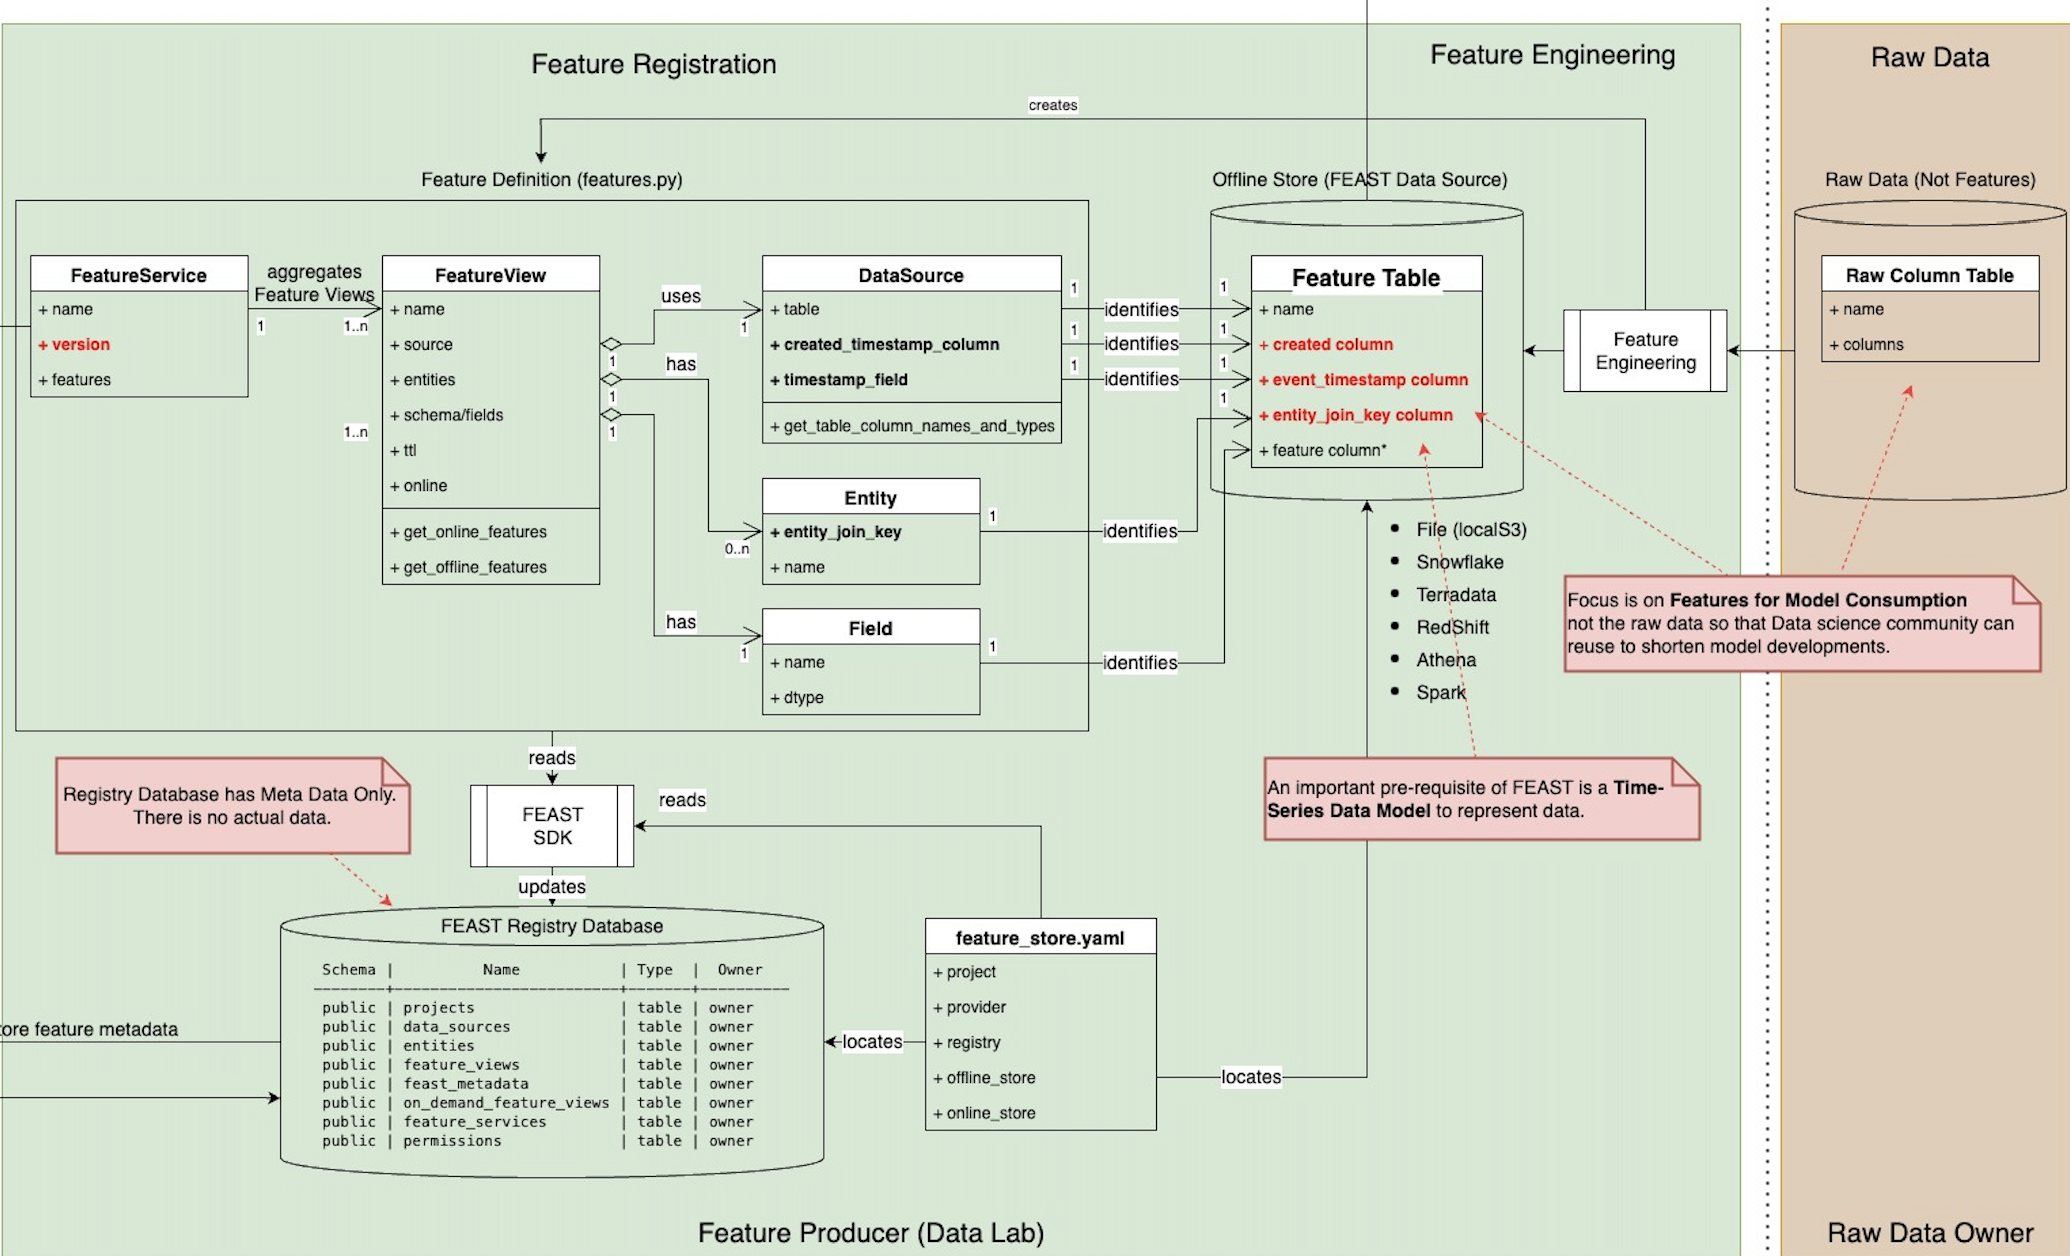

# Setup

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import os
import sys
import subprocess
from datetime import (
    datetime,
    timedelta
)

import pandas as pd
from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
    Project,
    PushSource,
    RequestSource,
    RepoConfig,
)
from feast.repo_config import (
    RegistryConfig
)
from feast.infra.registry.sql import (
    SqlRegistryConfig
)
from feast.feature_logging import LoggingConfig
from feast.infra.offline_stores.file_source import FileLoggingDestination
from feast.infra.online_stores.sqlite import (
    SqliteOnlineStoreConfig
)
from feast.infra.offline_stores.contrib.postgres_offline_store.postgres import (
    PostgreSQLOfflineStoreConfig
)
# https://github.com/feast-dev/feast/issues/5613
# No module named 'feast.infra.online_stores.contrib
# from feast.infra.online_stores.contrib.postgres import (
#     PostgreSQLOnlineStoreConfig
# )
from feast.on_demand_feature_view import on_demand_feature_view
from feast.types import (
    Float32, Float64, Int64
)
from feast.value_type import (
    ValueType
)
from feast import FeatureStore
from feast.data_source import PushMode

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
pythonpath = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'deployment/feast/feature_repository')
)
if pythonpath not in sys.path:
    sys.path.append(pythonpath)

In [4]:
%load_ext autoreload
%autoreload 2

from psql import (
    batch_insert_with_progress,
    exists_table,
    get_all_tables,
    truncate,
    select_one,
    get_password_from_pgpass,
)
from utility import (
    read_yaml
)

In [5]:
NOTEBOOK_DIR: str = os.getcwd()
FEATURE_REPO_DIR: str = os.path.abspath(os.sep.join(
    [NOTEBOOK_DIR, "../deployment/feast/feature_repository"]
))

--- 
# FEAST Project

### Project as Namespace

* [FEAST Project](https://docs.feast.dev/getting-started/concepts/project)

> Projects provide complete isolation of feature stores at the infrastructure level. This is accomplished through **resource namespacing, e.g., prefixing table names with the associated project**. Each project should be considered a completely separate universe of entities and features.

<img src=image/feast_project_structure.png align="left" width=300/>

## Project Configuration

```feast configuration``` shows the project configurations defined in ```feature_store.yaml```.

The following top-level configuration options exist in the feature_store.yaml file.

| Item          | Description                                                                | Value                                                  |
|---------------|----------------------------------------------------------------------------|--------------------------------------------------------|
| project       | a namespace for the entire feature store.                                  |                                                        |
| provider      | provider is an implementation of a feature store, like Terraform provider. | local aws gcp                                          |
| registry      | central catalog of all feature definitions and their related metadata.     | data/registry.db s3://feast-test-s3-bucket/registry.pb |
| online_store  | Low latency feature server implementation.                                 | ```type: dynamodb ```               |
| offline_store | Computation Engine for Transformation and Materialisation.                 | ```type: redshift ```              |


# Feature Registration

## Feature Definitions

In [6]:
"""Feature definition
"""
from datetime import timedelta

from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    Project,
)
from feast.infra.offline_stores.contrib.postgres_offline_store.postgres_source import (
    PostgreSQLSource,
)

from feast.feature_logging import LoggingConfig
from feast.infra.offline_stores.file_source import FileLoggingDestination
from feast.types import Float32, Int64

from utility import (
    get_yaml_value
)


project = Project(
    name=get_yaml_value(f"{FEATURE_REPO_DIR}/feature_store.yaml", "project", "customer_credit_risk"),
    description="A project for customer credit risk"
)

# https://docs.feast.dev/reference/data-sources/postgres
credit_risk_feature_source = PostgreSQLSource(
    name="customer_credit_risk_feature_source",
    # The table name must match with the offline table insert SQL.
    query="SELECT * FROM credit.customer_credit_risk_offline_features",
    timestamp_field="event_timestamp",
    created_timestamp_column="created",
)

customer = Entity(name="customer", join_keys=["entity_id"])

credit_risk_feature_view = FeatureView(
    name="customer_credit_risk_feature_view",
    entities=[customer],
    ttl=timedelta(minutes=1),
    # The list of features defined below act as a schema to both define features
    # for both materialization of features into a store, and are used as references
    # during retrieval for building a training dataset or serving features
    schema=[
        Field(name="risk", dtype=Float32),
        Field(name="purpose_business", dtype=Float32),
        Field(name="purpose_car", dtype=Float32),
        Field(name="purpose_domestic_appliances", dtype=Float32),
        Field(name="purpose_education", dtype=Float32),
        Field(name="purpose_furniture_equipment", dtype=Float32),
        Field(name="purpose_radio_tv", dtype=Float32),
        Field(name="purpose_repairs", dtype=Float32),
        Field(name="purpose_vacation_others", dtype=Float32),
        Field(name="gender_female", dtype=Float32),
        Field(name="gender_male", dtype=Float32),
        Field(name="housing_free", dtype=Float32),
        Field(name="housing_own", dtype=Float32),
        Field(name="housing_rent", dtype=Float32),
        Field(name="saving_accounts_little", dtype=Float32),
        Field(name="saving_accounts_moderate", dtype=Float32),
        Field(name="saving_accounts_no_inf", dtype=Float32),
        Field(name="saving_accounts_quite_rich", dtype=Float32),
        Field(name="saving_accounts_rich", dtype=Float32),
        Field(name="checking_account_little", dtype=Float32),
        Field(name="checking_account_moderate", dtype=Float32),
        Field(name="checking_account_no_inf", dtype=Float32),
        Field(name="checking_account_rich", dtype=Float32),
        Field(name="generation_student", dtype=Float32),
        Field(name="generation_young", dtype=Float32),
        Field(name="generation_adult", dtype=Float32),
        Field(name="generation_senior", dtype=Float32),
        Field(name="job_0", dtype=Float32),
        Field(name="job_1", dtype=Float32),
        Field(name="job_2", dtype=Float32),
        Field(name="job_3", dtype=Float32),
        Field(name="amount_0", dtype=Float32),
        Field(name="amount_1", dtype=Float32),
        Field(name="amount_2", dtype=Float32),
        Field(name="amount_3", dtype=Float32),
        Field(name="amount_4", dtype=Float32),
        # Field(name="avg_daily_trips", dtype=Int64, description="Average daily trips"),
    ],
    source=credit_risk_feature_source,             # Link to the raw data storage technology
    online=True,                                    # Tell FEAST to materialise into online store.
)

# This groups features into a model version
customer_credit_risk_feature_service = FeatureService(
    name="customer_credit_risk_feature_service",
    description="Features for Customer Credit Dirk Model",
    tags={
        "version": "0.1"
    },
    features=[
        credit_risk_feature_view,
    ],
    logging_config=LoggingConfig(
        destination=FileLoggingDestination(path="data")
    ),
)


/var/folders/_y/676ck7wn74q07wgfpd7v2sxh0000gp/T/ipykernel_94076/1117293706.py:39: DeprecationWarning: Entity value_type will be mandatory in the next release. Please specify a value_type for entity 'customer'.
  customer = Entity(name="customer", join_keys=["entity_id"])


In [7]:
feature_store_config = read_yaml(f"{FEATURE_REPO_DIR}/feature_store.yaml")
repo_config = RepoConfig(
    registry=SqlRegistryConfig(
        path="postgresql+psycopg2://postgres@localhost:5432/feast_registry", 
        registry_type="sql",
        sqlalchemy_config_kwargs={
            "echo": False,
            "pool_pre_ping": True,
        }
    ),
    project="customer_credit_risk",
    provider="local",
    offline_store=PostgreSQLOfflineStoreConfig(**feature_store_config['offline_store']),
    # https://github.com/feast-dev/feast/issues/5613
    # online_store=PostgreSQLOnlineStoreConfig(**feature_store_config['online_store'])
    online_store=SqliteOnlineStoreConfig(path=f'{FEATURE_REPO_DIR}/data/online_store.db')
)

## Register Features

NOTE: FEAST **does not verify** if there are corresponding columns in the offline store for the Fields defined in the Feature View.


In [8]:
feature_store = FeatureStore(config=repo_config)

In [9]:
feature_store.apply(
    objects=[
        project,
        customer,
        credit_risk_feature_source,
        credit_risk_feature_view,
        customer_credit_risk_feature_service
    ]
)

## Result

In [10]:
for project in feature_store.list_projects():
    print(project)

for fv in feature_store.list_feature_views():
    print(f"FeatureView: {fv.name}")
    for feature in fv.features:
        print(f"  Feature: {feature.name} ({feature.dtype})")

for fs in feature_store.list_feature_services():
    print(f"\nFeatureService: {fs.name}")
    for projection in fs.feature_view_projections:
        print(f"  FeatureProjection: {projection.name}")
        for feature in projection.features:
            print(f"    Feature: {feature.name} ({feature.dtype})")

{
  "spec": {
    "name": "customer_credit_risk",
    "description": "A project for customer credit risk"
  },
  "meta": {
    "createdTimestamp": "2025-09-16T23:14:16.735489Z",
    "lastUpdatedTimestamp": "2025-09-16T23:14:16.735489Z"
  }
}
FeatureView: customer_credit_risk_feature_view
  Feature: risk (Float32)
  Feature: purpose_business (Float32)
  Feature: purpose_car (Float32)
  Feature: purpose_domestic_appliances (Float32)
  Feature: purpose_education (Float32)
  Feature: purpose_furniture_equipment (Float32)
  Feature: purpose_radio_tv (Float32)
  Feature: purpose_repairs (Float32)
  Feature: purpose_vacation_others (Float32)
  Feature: gender_female (Float32)
  Feature: gender_male (Float32)
  Feature: housing_free (Float32)
  Feature: housing_own (Float32)
  Feature: housing_rent (Float32)
  Feature: saving_accounts_little (Float32)
  Feature: saving_accounts_moderate (Float32)
  Feature: saving_accounts_no_inf (Float32)
  Feature: saving_accounts_quite_rich (Float32)
  Feat